# Evaluation

In [62]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import csv
import sys
import json
import math
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score

In [63]:
ref_filename = '../../text-mining-workflow/corpora/psylle/Cpruni_occurrences_binary.json'
pred_ent_filename = '../../text-mining-workflow/extracted_psyllid_entities.txt'
pred_rel_filename = '../../text-mining-workflow/extracted_psyllid_relations.txt'

## Entity Evaluation

with open(ref_filename) as f:
    reference = json.load(f)
ref_documents = set(ref['common']['filename'] for ref in reference)
ref_entities = set()
for ref in reference:
    fn = ref['common']['filename']
    ref_entities.add(hashabledict(ref['left']))
    ref_entities.add(hashabledict(ref['right']))
for ref_entity in ref_entities:
    for a,v in ref_entity.items():
        print(a)


},
                    "pred": {
        

### Evaluation Formulas

In [64]:
# Either reference and prediction document names are the same
def same_doc(ref, pred):
    return pred == ref or pred == ref + '_translation'


# Similarity between vactors
def sim_vector(ref, pred):
    for token1 in word_tokenize(ref['acceptedNameUsage'].lower()):
        for token2 in word_tokenize(pred['CANONICAL'].lower()):
            if token1==token2:
                return 1.0
    return 0.0

# Similarity between locations
def sim_location(ref, pred):
    for token1 in word_tokenize(ref['country'].lower()):
        for token2 in word_tokenize(pred['FORM'].lower()):
            if token1==token2:
                return 1.0
    return 0.0


# Similarity between hosts
def sim_host(ref, pred):
    for token1 in word_tokenize(ref['hostPlantLatinName'].lower()):
        for token2 in word_tokenize(pred['CANONICAL'].lower()):
            if token1==token2:
                return 1.0

# Similarity between dates
def sim_date(ref, pred):
    if ref['eventDate'][-4:] == pred['FORM']:
        return 1.0
    return 0.0


TYPES = ('vector', 'location', 'host', 'date')

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))
        

### Form Pairs

In [65]:

sim_fun = {
    'vector': sim_vector,
    'location': sim_location,
    'host': sim_host,
    'date': sim_date
}


def sim(ref, pred):
    if ref['type'] != pred['TYPE']:
        return 0.0
    if not same_doc(ref['filename'], pred['DOC']):
        return 0.0
    return sim_fun[ref['type']](ref, pred)


def find_best_ent(paired_pred, ref_ent):
    max_sim = 0.0
    best_pred = None
    for pred_ent in pred_entities:
        if pred_ent in paired_pred:
            continue
        s = sim(ref_ent, pred_ent)
        if s == 0.0:
            continue
        if s > max_sim:
            max_sim = s
            best_pred = pred_ent
    return best_pred, max_sim


def pair_filter(pair, doc=None, type_=None, cat=None):
    r = pair['ref']
    p = pair['pred']
    if doc is not None:
        if r is not None and r['filename'] != doc:
            return False
        if p is not None and not same_doc(doc, p['DOC']):
            return False
    if type_ is not None:
        if r is not None and r['type'] != type_:
            return False
        if p is not None and p['TYPE'] != type_:
            return False
    if cat is not None:
        return cat == pair['cat']
    return True


### Evaluate

In [66]:
       
with open(ref_filename) as f:
    reference = json.load(f)
ref_documents = set(ref['common']['filename'] for ref in reference)
ref_entities = set()
for ref in reference:
    fn = ref['common']['filename']
    ref_entities.add(hashabledict(ref['left']))
    ref_entities.add(hashabledict(ref['right']))


with open(pred_ent_filename, newline='') as f:
    entcsv = csv.DictReader(f, delimiter='\t')
    pred_entities = set(hashabledict(row) for row in entcsv)


with open(pred_rel_filename, newline='') as f:
    relcsv = csv.DictReader(f, delimiter='\t')
    pred_relations = set(hashabledict(row) for row in relcsv)



TRUE_POSITIVE = 'True Positive'
FALSE_POSITIVE = 'False Positive'
FALSE_NEGATIVE = 'False Negative'


ent_pairs = []
paired_pred = set()
for ref_ent in ref_entities:
    pred_ent, s = find_best_ent(paired_pred, ref_ent)
    if pred_ent is not None:
        paired_pred.add(pred_ent)
        cat = TRUE_POSITIVE
    else:
        cat = FALSE_NEGATIVE
    ent_pairs.append({'ref': ref_ent, 'pred': pred_ent, 'sim': s, 'cat': cat})
for pred_ent in pred_entities:
    if pred_ent not in paired_pred:
        ent_pairs.append({'ref': None, 'pred': pred_ent, 'sim': 0.0, 'cat': FALSE_POSITIVE})


def evaluate(pairs):
    tp = list(p for p in pairs if pair_filter(p, cat=TRUE_POSITIVE))
    fp = list(p for p in pairs if pair_filter(p, cat=FALSE_POSITIVE))
    fn = list(p for p in pairs if pair_filter(p, cat=FALSE_NEGATIVE))
    if len(tp) + len(fn) == 0:
        recall = math.nan
    else:
        recall = float(len(tp)) / (len(tp) + len(fn))
    if len(tp) + len(fp) == 0:
        precision = math.nan
    else:
        precision = float(len(tp)) / (len(tp) + len(fp))
    if recall + precision == 0:
        f1 = math.nan
    else:
        f1 = 2 * recall * precision / (recall + precision)
    return recall, precision, f1


ent_eval = {}
for doc in ref_documents:
    ent_doc_eval = {}
    for type_ in TYPES:
        pairs = list(p for p in ent_pairs if pair_filter(p, doc=doc, type_=type_))
        recall, precision, f1 = evaluate(pairs)
        ent_doc_eval[type_] = {
            'pairs': pairs,
            'recall': recall,
            'precision': precision,
            'f1': f1
        }
    ent_eval[doc] = ent_doc_eval
    recall, precision, f1 = evaluate(ent_pairs)
    ent_eval['global'] = {
        'recall': recall,
        'precision': precision,
        'f1': f1
    }

comparison_filepath = 'data/first_comparison.json'

with open(comparison_filepath, 'w+') as f:
    json.dump(ent_eval, f, indent=4)

## JSON to DF

ref = []
for docname,entities in ent_eval.items():
    for entname,pairs_n_scores in entities.items():
        for pair in pairs_n_scores['pairs']:
            attributes = set()
            for attribute in pair['ref'].items()+pair['pred'].items():
                attributes.add(attribute)
            

In [121]:
from collections import defaultdict

ref_df = dict(docname=[],entname=[])
pred_df = dict(docname=[],entname=[])

for docname,entities in ent_eval.items():
    ref_df['docname'].append(docname)
    ref_df['entname'].append(entname)
    
    for entname,pairs_n_scores in entities.items():
        pred_df['docname'].append(docname)
        pred_df['entname'].append(entname)
        try:
            for pair in pairs_n_scores['pairs']:
                try:
                    for a,v in pair['ref'].items():
                        if a not in ref_df.keys():
                            ref_df[a] = []
                        ref_df[a].append(v)
                except AttributeError:
                    pass
                try:
                    for a,v in pair['pred'].items():
                        if a not in ref_df.keys():
                            pred_df[a] = []
                        pred_df[a].append(v)
                except AttributeError:
                    pass
                sizes = []
                for k in ref_df.keys():
                    sizes.append(len(ref_df[k]))
                print(sizes)
                for k in ref_df.keys():
                    if len(ref_df[k]) < max(sizes):
                        ref_df[k].extend([math.nan]*(max(sizes) - len(ref_df[k])))
                
        except:
            pass

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 5]
[7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 7]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 9]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10]
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 11]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 12]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 13]
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 14]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 15]
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 16]
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 1

In [122]:
for k in ref_df.keys():
    print(k)
    print(len(ref_df[k]))

docname
1584
entname
1584
phylum
1584
class
1584
order
1584
suborder
1584
superfamily
1584
family
1584
subfamily
1584
genus
1584
acceptedNameUsage
1584
type
1584
filename
1584
country
1584
countryCode
1584
locality
1584
eventDate
1584
hostPlantFamily
1584
hostPlantLatinName
1584
hostPlantVernacularName
1584


# Scores

In [67]:
dummies = {'False Positive': (0,1),
            'False Negative': (1,0),
            'True Positive': (1,1),
            'True Negative': (0,0),
            }

In [68]:
dummy_data = []
for docname,entities in ent_eval.items():
    for entname,pairs_n_scores in entities.items():
        if type(pairs_n_scores) is float:
            continue
        for pair in pairs_n_scores['pairs']:
            label = pair['cat']
            dummy_data.append(dummies[label])

dummy_df = pd.DataFrame(dummy_data, columns =['ref', 'pred'])
dummy_df.head()

,ref,pred
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [69]:
ref_dummy, pred_dummy = dummy_df['ref'], dummy_df['pred']

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

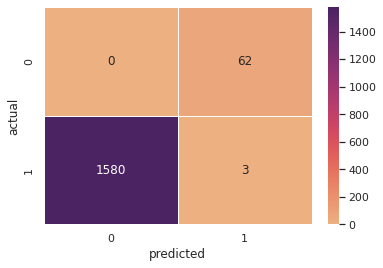

In [70]:
# plotting confusion matrix
conf_mat = confusion_matrix(ref_dummy, pred_dummy)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [71]:
print(classification_report(ref_dummy, pred_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.05      0.00      0.00      1583

    accuracy                           0.00      1645
   macro avg       0.02      0.00      0.00      1645
weighted avg       0.04      0.00      0.00      1645



In [78]:
with open(comparison_filepath, 'r') as f:
    df = pd.read_json(f)

In [79]:
df.head()

,1966_Loginova_psyllids_USSR,global,1901_Edwards_Cacopsylla_pruni_Norfolk,1908_Oshanin_Cacopsylla_pruni_Irkutsk,2015_Etropolska_Cacopsylla_pruni_Bulgaria,2005_MalenovskyLauterer_Hemiptera_Czech_Rep_Brno,2012_Batlle_IDENTIFICATION_AND_EPIDEMIOLOGY_OF,2007_Sauvion_BI60_Cacopsylla_pruni_France,1837_Curtis_Cacopsylla_pruni_Britain_page_220,1917_Pierce_manual_dangerous_insects_USA_impor,...,2008_matallah_thesis,2008_Labina_Psyllids_Rep_Altai,1880_Scott_psyllids_Russia,2020_Marie-Jeanne_spatial_genetic_structure_vector-borne_pathogen_phytoplasma_psyllid_prunus,1879_Norman_The_Entomologist s_monthly_magazine,1999_Tulowitzki_Faun-Oekol-Mitt_7_0441-0479,1893_Wustnei_Cacopsylla_pruni_Germany1,2017_Bodnar-Cacopsylla_pruni_Hungary,2010_Krizanac_ESFY_cacopsylla_pruni_Croatia,2007_Cocquempot_Faune_Psylles_Psylloidea_France
vector,"{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...",NaN,"{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...",...,"{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...","{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c..."
location,"{'pairs': [{'ref': {'country': 'Russia', 'coun...",NaN,{'pairs': [{'ref': {'country': 'United Kingdom...,"{'pairs': [{'ref': {'country': 'Austria', 'cou...","{'pairs': [{'ref': {'country': 'Bulgaria', 'co...",{'pairs': [{'ref': {'country': 'Czech Republic...,"{'pairs': [{'ref': {'country': 'Spain', 'count...","{'pairs': [{'ref': {'country': 'France', 'coun...","{'pairs': [{'ref': {'country': 'Ireland', 'cou...","{'pairs': [], 'recall': None, 'precision': Non...",...,"{'pairs': [{'ref': {'country': 'Algeria', 'cou...","{'pairs': [{'ref': {'country': 'Russia', 'coun...","{'pairs': [{'ref': {'country': 'Russia', 'coun...","{'pairs': [{'ref': {'country': 'France', 'coun...",{'pairs': [{'ref': {'country': 'United Kingdom...,"{'pairs': [{'ref': {'country': 'Germany', 'cou...","{'pairs': [{'ref': {'country': 'Germany', 'cou...","{'pairs': [{'ref': {'country': 'Hungary', 'cou...","{'pairs': [{'ref': {'country': 'Croatia', 'cou...","{'pairs': [{'ref': {'country': 'France', 'coun..."
host,"{'pairs': [], 'recall': None, 'precision': Non...",NaN,"{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...",{'pairs': [{'ref': {'hostPlantFamily': 'Rosace...,"{'pairs': [{'ref': {'hostPlantFamily': None, '...","{'pairs': [], 'recall': None, 'precision': Non...",{'pairs': [{'ref': {'hostPlantFamily': 'Rosace...,"{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...",...,"{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...",{'pairs': [{'ref': {'hostPlantFamily': 'Rosace...,"{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...","{'pairs': [], 'recall': None, 'precision': Non...",{'pairs': [{'ref': {'hostPlantFamily': 'Rosace...,"{'pairs': [], 'recall': None, 'precision': Non..."
date,"{'pairs': [{'ref': {'eventDate': '1966', 'type...",NaN,"{'pairs': [{'ref': {'eventDate': '1901', 'type...","{'pairs': [{'ref': {'eventDate': '1908', 'type...","{'pairs': [{'ref':

# Visualisation

In [73]:
from collections import Counter
from tools.visual import plot

In [74]:
counts = Counter(dummy_data)
counts

Counter({(1, 0): 1580, (0, 1): 62, (1, 1): 3})

In [75]:
counts2 = counts.copy()
all_dfs=[counts, counts, counts]
df = pd.DataFrame(all_dfs)
df['index'] = df.index
df.head()

,"(1, 0)","(0, 1)","(1, 1)",index
0,1580,62,3,0
1,1580,62,3,1
2,1580,62,3,2


In [76]:
x = 'ref'
y = 'pred'
palette = sns.color_palette('tab10',n_colors=2)

plot(x='index', hue= data=df,
    type='dist',
    swarm=True,
    #save_dir = save_dir,
    )

SyntaxError: invalid syntax (487782605.py, line 5)